In [1]:
%autosave 0

Autosave disabled


In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy.stats.distributions import chi2
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pandas import read_csv
from tabulate import tabulate
import pandas as pd
import io
import warnings
import matplotlib.pyplot as plt
from numpy import array
from datetime import datetime

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('fypdata.csv')#, parse_dates=['date'], index_col='date')
df['date']= pd.to_datetime(df['date'])
print(df.dtypes)
df.index = df.date
df.drop(columns = ["date", 'kibor', 'lendrate'], inplace = True)
print(df.shape)
df.tail()

date        datetime64[ns]
nplr               float64
kibor              float64
discrate           float64
lendrate           float64
exrate             float64
gdp                float64
crudeoil           float64
gexp               float64
lsm                float64
cpi                float64
psx                float64
dtype: object
(64, 9)


,nplr,discrate,exrate,gdp,crudeoil,gexp,lsm,cpi,psx
date,,,,,,,,,
2019-12-01,4.84,13.25,155.51,1.91,56.87,4.27,150.11,130.17,40.74
2020-03-01,4.94,12.50,156.06,1.91,45.78,-4.74,127.14,132.12,29.23
2020-06-01,5.10,8.00,163.89,1.91,27.88,-2.52,122.46,131.23,34.42
2020-09-01,5.02,7.00,166.96,-0.39,40.92,9.53,138.08,136.64,40.57
2020-12-01,4.77,7.00,160.83,-0.39,42.65,5.02,166.23,141.12,43.76


## nplr = Non-Performing Loans
## discrate = discount rate
## exrate = exchange rate
## gexp = growth in export
## psx = Pakistan Stock Exchange index

<AxesSubplot:xlabel='date'>

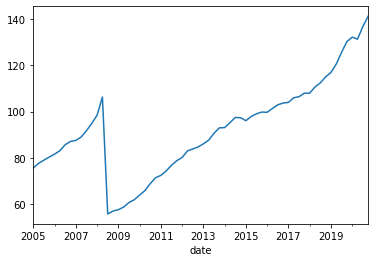

In [4]:
df['cpi'].plot()

# ADF test

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
passing_data=adfuller(df.cpi)

In [7]:
def adf_test(df):
    result=adfuller(df)
    labels = ['Test parameters', 'p-value','#Lags Used','Dataset observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Dataset is stationary")
    else:
        print("Dataset is non-stationary ")

In [8]:
adf_test(df.cpi)

Test parameters : -0.3391226724907197
p-value : 0.919777719093647
#Lags Used : 0
Dataset observations : 63
Dataset is non-stationary 


# KPSS test

In [9]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    if kpss_output[1] >= 0.05:
        print("Dataset have no trend")
    else:
        print("Dataset have trend ")

In [10]:
kpss_test(df.cpi)

Results of KPSS Test:
Test Statistic           1.018603
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Dataset have trend 


# differencing for stationarity

In [11]:
df['Differencing_cpi']=df['cpi'].diff()

In [12]:
adf_test(df['Differencing_cpi'].dropna())

Test parameters : -8.558259048132284
p-value : 8.837709056259083e-14
#Lags Used : 0
Dataset observations : 62
Dataset is stationary


In [13]:
kpss_test(df['Differencing_cpi'].dropna())

Results of KPSS Test:
Test Statistic           0.178946
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Dataset have no trend


<AxesSubplot:xlabel='date'>

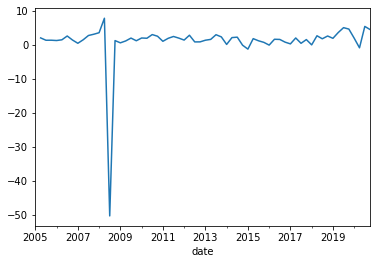

In [14]:
df['Differencing_cpi'].plot()

from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
#series = read_csv('airline-passengers.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# for q lags

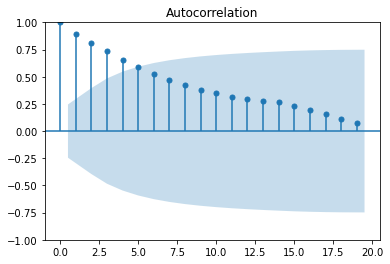

In [16]:
plot_acf(df.cpi) #5 lags
plt.show()

# for p lags

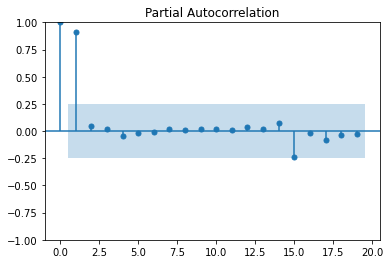

In [17]:
plot_pacf(df.cpi) #1
plt.show()

 FOR APPLYING ARMA, KEEP d=0, AND USE p AND q ONLY ON DIFFERENCED DATA SET (IF NOT STATIONARY) ELSE ON VAR. DIRECTLY

# auto ARMA

In [18]:
model_1 = auto_arima(df['Differencing_cpi'].dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5,  # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=425.482, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=421.863, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=423.491, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=423.484, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=422.366, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.337 seconds


In [19]:
model_1 = ARIMA(df['Differencing_cpi'].dropna(),order=(0,0,0))
auto_arma_model = model_1.fit()
auto_arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Differencing_cpi   No. Observations:                   63
Model:                          ARIMA   Log Likelihood                -209.183
Date:                Thu, 13 Apr 2023   AIC                            422.366
Time:                        22:47:50   BIC                            426.652
Sample:                    06-01-2005   HQIC                           424.052
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0382      3.584      0.290      0.772      -5.987       8.063
sigma2        44.8290      6.515      6.881      0.000      32.060      57.598
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              7712.44
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -7.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# forecast

<AxesSubplot:xlabel='date'>

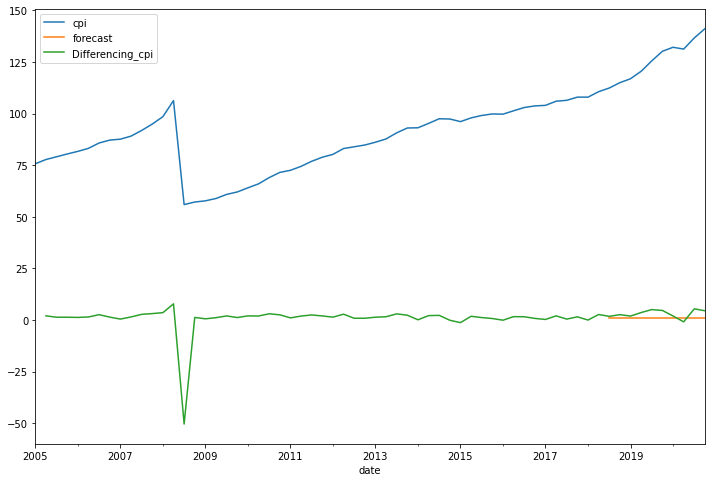

In [20]:
df['forecast']=auto_arma_model.predict(start=53,end=64,dynamic=True)
df[['cpi','forecast', 'Differencing_cpi']].plot(figsize=(12,8))

# DW test

In [21]:
sm.stats.durbin_watson(auto_arma_model.resid.values)

2.1972628065923576